# Predicting the rating a reviewer will give a restaurant using Featuretools and the nlp_primitives library

<a style="margin:30px" href="https://www.featuretools.com">
    <img width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</a>

**When customers visit restaurants, they will oftentimes leave a review of some sort. Using data from TripAdvisor, we investigate how this textual data can be used to predict the overall thoughts of the customer on that restuarant represented in a star rating.**

In this tutorial, we show how [Featuretools](https://www.featuretools.com) can be used alongside the [nlp-primitives](https://pypi.org/project/nlp-primitives/) library to train an accurate machine learning model that can predict a customer's rating of a restaurant based on the text of their review and some information about the restaurant.

*Note: If you are running this notebook yourself, refer to the [readme](https://github.com/FeatureLabs/predict-restaurant-rating/blob/master/README.md) on Github for instructions to download the dataset*

## Highlights

* We use the nlp-primitives library to create structured data from unstructured, hard to parse, textual data
* We build a pipeline that it can be reused for numerous NLP prediction problems (You can try this yourself!)
* We use these primitives alongside Featuretools' `dfs` method to create as much information as possible from a dataset containing only two entities.

In [1]:
import nltk
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import nlp_primitives
import featuretools as ft
import featuretools.variable_types as vtypes
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import numpy as np

from featuretools.primitives import *
from featuretools.selection import remove_low_information_features
from nlp_primitives import (
    DiversityScore,
    LSA,
    MeanCharactersPerWord,
    PartOfSpeechCount,
    PolarityScore, 
    PunctuationCount,
    StopwordCount,
    TitleWordCount,
    UniversalSentenceEncoder,
    UpperCaseCount)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier

print('Featuretools version {}'.format(ft.__version__))

Featuretools version 0.9.1


## Step 1. Load Data
We start by loading in the data from our machine. This data is from a kaggle dataset, and instuctions on how to download it and can be found in the read me on github. Once it has been downloaded, run `python data_to_entityset.py` on the command line in the predict-restaurant-rating folder with the downloaded dataset in that same folder, making sure to rename that dataset as `reviews.json`. This process will create an entityset for use with this tutorial. This data includes two entity sets: The restaurants entityset, which includes the name, address, price, star-rating, and several other pieces of information about each restaurant in the data, and the reviews entityset, which includes the title of the review, date of the review, and text of the review.

In [2]:
es = ft.read_entityset('./predict-restaurant-rating/restaurants_entity_set')
es

Entityset: es
  Entities:
    restaurants [Rows: 147, Columns: 28]
    reviews [Rows: 14700, Columns: 6]
  Relationships:
    reviews.restaurant_id -> restaurants.id

### Visualize Data Distribution
This is a multiclass classification problem, and we can see here that the data is skewed towards higher reviews, but that there are reviews in every category, from 1-5 stars.

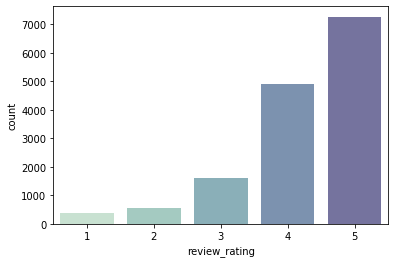

In [3]:
df = pd.read_pickle('./predict-restaurant-rating/visualization_df')

col = sns.color_palette("Blues")
sns.countplot(x=df['review_rating'], palette = sns.cubehelix_palette(8, start=1, rot=-.75))

In [4]:
es['reviews'].convert_variable_type('review_rating', ft.variable_types.Categorical)
rating_df = es['reviews'].df[['index', 'review_rating']]
es['reviews']

Entity: reviews
  Variables:
    index (dtype: index)
    review_date (dtype: datetime)
    review_text (dtype: text)
    restaurant_id (dtype: id)
    review_title (dtype: text)
    review_rating (dtype: categorical)
  Shape:
    (Rows: 14700, Columns: 6)

In [5]:
es.add_interesting_values()

## Step 2. Create Feature Matrix
Here we choose the features we wish to include in the training (in this case all of them), and calculate the training feature matrix. We have set the chunk size to the size of the training set, because the "USE" or Universal Sentence Encoding Feature takes a disproporionately long time to run if calculated in chunks rather than all at once.

In [6]:
trans = [DiversityScore,
         LSA,
         MeanCharactersPerWord,
         PartOfSpeechCount,
         PolarityScore, 
         PunctuationCount,
         StopwordCount,
         TitleWordCount,
         UniversalSentenceEncoder,
         UpperCaseCount]

ignore = {'restaurants': ['rating'],
          'reviews': ['review_rating']}
drop_contains = ['(reviews.UNIVERSAL']

features = ft.dfs(entityset=es,
                  target_entity='reviews',
                  trans_primitives=trans,
                  verbose=True,
                  features_only=True,
                  ignore_variables=ignore,
                  drop_contains=drop_contains,
                  max_depth=4)

Built 336 features


Now we calculate the features of the test set, using the same chunk size method to optimize runtime for the "USE" primitive.

In [7]:
feature_matrix = ft.calculate_feature_matrix(features=features,
                                             entityset=es,
                                             verbose=True)

Elapsed: 10:20 | Progress: 100%|██████████


In [8]:
feature_matrix2, features2 = remove_low_information_features(feature_matrix, features)

In [9]:
features2

[<Feature: restaurant_id>,
 <Feature: DIVERSITY_SCORE(review_text)>,
 <Feature: DIVERSITY_SCORE(review_title)>,
 <Feature: MEAN_CHARACTERS_PER_WORD(review_text)>,
 <Feature: MEAN_CHARACTERS_PER_WORD(review_title)>,
 <Feature: POLARITY_SCORE(review_text)>,
 <Feature: POLARITY_SCORE(review_title)>,
 <Feature: PUNCTUATION_COUNT(review_text)>,
 <Feature: PUNCTUATION_COUNT(review_title)>,
 <Feature: STOPWORD_COUNT(review_text)>,
 <Feature: STOPWORD_COUNT(review_title)>,
 <Feature: TITLE_WORD_COUNT(review_text)>,
 <Feature: TITLE_WORD_COUNT(review_title)>,
 <Feature: UPPER_CASE_COUNT(review_text)>,
 <Feature: UPPER_CASE_COUNT(review_title)>,
 <Feature: restaurants.meal_cater>,
 <Feature: restaurants.meal_deliver>,
 <Feature: restaurants.options_glutenfree>,
 <Feature: restaurants.options_lowfat>,
 <Feature: restaurants.options_organic>,
 <Feature: restaurants.options_vegan>,
 <Feature: restaurants.parking_free>,
 <Feature: restaurants.parking_garage>,
 <Feature: restaurants.parking_lot>,
 <F

## Step 3. Dividing the data
We must do two things in this step: split the data into a training set and a testing set, and separate the labels from the feature matrix. We will use the train_test_split functionality of sklearn to do this.

In [10]:
feature_matrix2 = feature_matrix2.reindex(rating_df.index)

In [11]:
y = rating_df.pop('review_rating')

train_feature_matrix, test_feature_matrix, y_train, y_test = train_test_split(feature_matrix2, y, test_size=0.15, stratify=y)

## Step 4. Machine Learning
Here we create and test various machine learning models from sklearn using the feature matrix.

In [12]:
lgr = LogisticRegression(solver='liblinear', multi_class='auto')
lgr.fit(train_feature_matrix, y_train)
lgr.score(test_feature_matrix, y_test)

/Users/featurelabs/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.6308390022675737

In [13]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(train_feature_matrix, y_train)
hgbc.score(test_feature_matrix, y_test)

0.691156462585034

In [14]:
rfc = RandomForestClassifier(n_estimators=100, class_weight = "balanced", n_jobs=-1)
rfc.fit(train_feature_matrix, y_train)
rfc.score(test_feature_matrix, y_test)

0.6390022675736962

Here we can observe the feature importances for this model, and see that the Universal Sentence Encoder features and the polarity score are the most influential in this model.

In [15]:
headers = ["name", "score"]
values = pd.DataFrame(sorted(zip(train_feature_matrix.columns, rfc.feature_importances_), key=lambda x: x[1] * -1))

values.head(10)

,0,1
0,UNIVERSAL_SENTENCE_ENCODER(review_text)[415],0.014275
1,UNIVERSAL_SENTENCE_ENCODER(review_title)[415],0.013241
2,POLARITY_SCORE(review_text),0.012991
3,UNIVERSAL_SENTENCE_ENCODER(review_title)[28],0.011581
4,UNIVERSAL_SENTENCE_ENCODER(review_text)[348],0.008773
5,UNIVERSAL_SENTENCE_ENCODER(review_text)[375],0.008727
6,UNIVERSAL_SENTENCE_ENCODER(review_text)[28],0.007676
7,POLARITY_SCORE(review_title),0.006912
8,UNIVERSAL_SENTENCE_ENCODER(review_text)[147],0.006329
9,UNIVERSAL_SENTENCE_ENCODER(review_text)[289],0.006249


In [16]:
vot = VotingClassifier(voting='soft', estimators=[('lgr', lgr), ('rfc', rfc), ('hgbc', hgbc)], weights=[3, 1, 6])
vot.fit(train_feature_matrix, y_train)
vot.score(test_feature_matrix, y_test)

/Users/featurelabs/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.690702947845805

So, we can see that the highest score we can get with a model is around 70%, which might seem like a pretty poor result. However, given that it is a 5 class classification problem, it is not too bad a score. Furthermore, by examining the confusion matrix, we can see where the model goes wrong and get a better sense of how far off the model is with its predictions.

In [17]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    title = 'Normalized confusion matrix'

    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

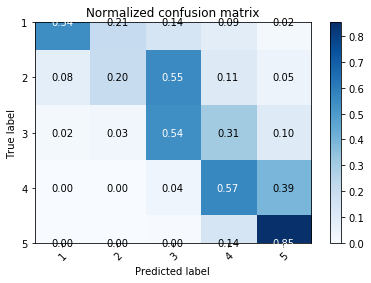

In [18]:
plot_confusion_matrix(y_test, 
                      vot.predict(test_feature_matrix), 
                      ['1', '2', '3', '4', '5'])

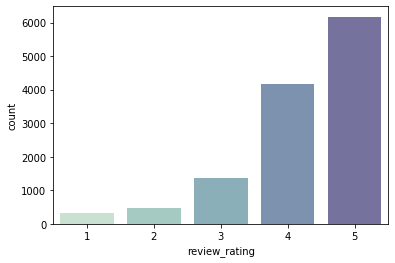

In [19]:
sns.countplot(x=y_train, palette = sns.cubehelix_palette(8, start=1, rot=-.75))

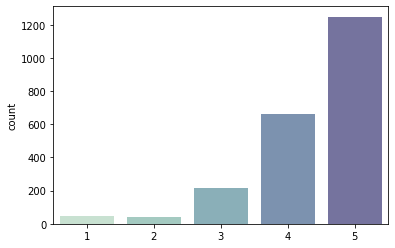

In [20]:
sns.countplot(x=vot.predict(test_feature_matrix), palette = sns.cubehelix_palette(8, start=1, rot=-.75))

So, from looking at the confusion matrix, it is clear that the model is pretty accurate, for when it predicts the star rating wrong, it is generally within one star of the correct answer, which is much better than a model that has the same accuracy but then predicts the wrong ones as a star rating that is very different from the actual outcome. Furthermore, as we can see, the predictions have about the same distribution of star ratings as the training data, which suggests that this model is pretty accurate, and doesn't just predict all of the test data to be in the most frequent category.

## 5. Next Steps

This is an end-to-end example of going from raw text data to a machine learning model with Natural Language Processing Primitives. However, in a problem such as this one, ideally there would be more data available, especially pertaining to the customer who wrote each review, that would make the data structure more complicated, but also give the model more insight into patterns of each reviewer, so that it could make more accurate predictions. Luckily, Featuretools makes it easy to deal with relational datasets, and so this new extra data would be relatively simple to add into the pipeline, just requiring the addition of a new entity to the entityset, and a recalculation of DFS and the following steps with the newly modified entityset.


<p>
    <img src="https://www.featurelabs.com/wp-content/uploads/2017/12/logo.png" alt="Featuretools" />
</p>

Featuretools was created by the developers at [Feature Labs](https://www.featurelabs.com/). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.featurelabs.com/contact/).